In [1]:
import numpy as np
import scanpy as sc
import squidpy as sq
from anndata import AnnData
import sepal
import sepal.datasets as d
import sepal.models as m
import sepal.utils as ut

sc.logging.print_header()
sq.__version__
%load_ext autoreload
%autoreload 2
%load_ext lab_black
pth = "./../sepal/data/real/melanoma.tsv.gz"
raw_data = d.RawData(
    pth,
)
raw_data.cnt = ut.filter_genes(raw_data.cnt, min_expr=10, min_occur=5)
data = m.ST1K(raw_data, eps=0.1)

scanpy==1.8.0.dev78+gc488909a anndata==0.7.5 umap==0.4.6 numpy==1.20.1 scipy==1.6.0 pandas==1.2.3 scikit-learn==0.22 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


In [2]:
times = m.propagate(data, normalize=True, scale=False, num_workers=8)

  0%|          | 0/9956 [00:00<?, ?it/s]

[INFO] : Using 8 workers
[INFO] : Saturated Spots : 203


100%|██████████| 9956/9956 [01:11<00:00, 138.35it/s]


In [3]:
snidx = data.get_satnbr_idx(data.saturated)
unidx = data.get_unsatnbr_idx(data.unsaturated)

In [4]:
coords = [i.split("x") for i in raw_data.cnt.index.values]
spatial = np.stack(coords).astype(int)

In [5]:
spatial.shape

(279, 2)

In [6]:
ncnt = raw_data.cnt.values
ncnt = ut.normalize_expression(ncnt, c=2)
colMax = np.max(np.abs(ncnt), axis=0).reshape(1, -1)
ncnt = np.divide(ncnt, colMax, where=colMax > 0)
ncnt = ncnt.astype(float)

In [7]:
adata = AnnData(
    ncnt,
)
adata.obs.index = raw_data.cnt.index
adata.var.index = raw_data.cnt.columns
adata.obsm["spatial"] = spatial

In [8]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [9]:
adata.obs["unsaturated"] = [
    1 if (i in data.unsaturated) else 0 for i in np.arange(adata.shape[0])
]
adata.obs["saturated"] = [
    1 if (i in data.saturated) else 0 for i in np.arange(adata.shape[0])
]

In [10]:
sq.gr.spatial_neighbors(adata, radius=1)

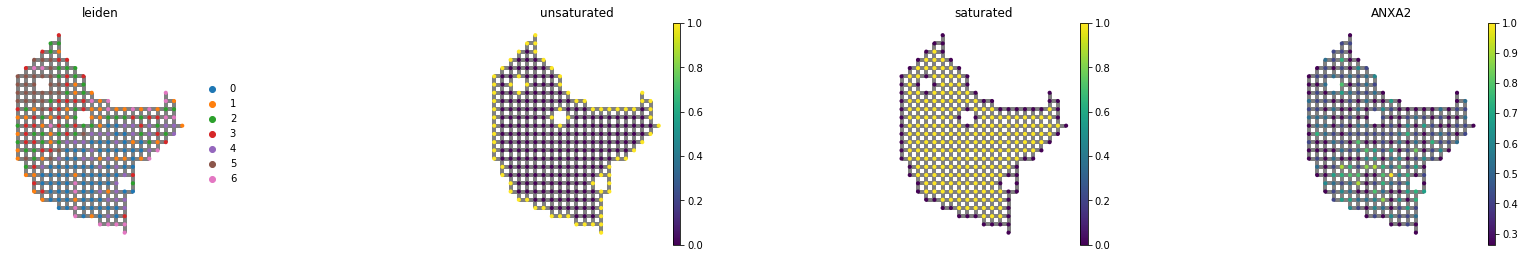

In [11]:
sc.pl.spatial(
    adata,
    spot_size=0.5,
    color=["leiden", "unsaturated", "saturated", "ANXA2"],
    neighbors_key="spatial_neighbors",
    edges=True,
    edges_width=4,
    frameon=False,
)

In [12]:
from squidpy.gr._sepal import sepal

In [35]:
sepal(adata, n_iter=2000, max_nbrs=4, n_jobs=4)

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


  0%|          | 0/9956 [00:00<?, ?/s]

In [36]:
adata.uns["sepal_score"]

,sepal_score
CCL21,1.533
MCAM,1.447
LTB,1.390
COL1A1,1.336
MLANA,1.222
...,...
NTM,0.135
LYVE1,0.128
LINC01215,0.126
FBXO41,0.095


Text(0.5, 1.0, 'spearman_0.86192')

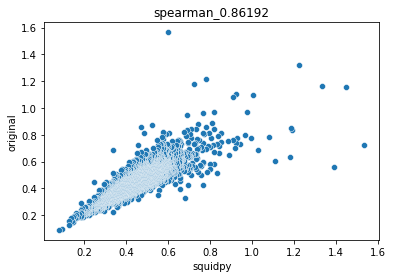

In [37]:
sepal_squidpy = adata.uns["sepal_score"]["sepal_score"].values
sepal_original = times.loc[adata.uns["sepal_score"].index.values].values.flatten()

from scipy.stats import pearsonr, spearmanr
import seaborn as sns

g = sns.scatterplot(x=sepal_squidpy, y=sepal_original)
g.set_xlabel("squidpy")
g.set_ylabel("original")
p = spearmanr(sepal_squidpy, sepal_original)[0]
g.set_title(f"spearman_{round(p, 5)}")

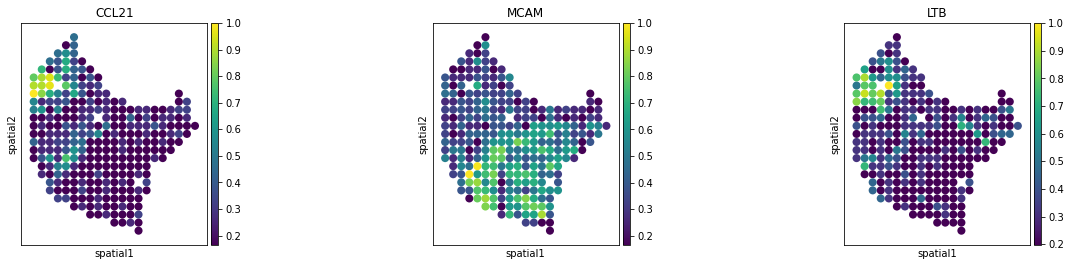

In [38]:
sc.pl.spatial(adata, color=["CCL21", "MCAM", "LTB"], spot_size=1)